# A3TGCN


Graph edges are formed using cumulative data from 21 months from November 2021 to July 2023.  

An edge is defined between 2 nodes(companies) if one or more politicians invests in both companies in that timeframe. The edge is given a weight equivalent to the total number of investors in both companies, which is then max-normalized to [0,1].

In [1]:
import torch
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from torch_geometric_temporal.signal import temporal_signal_split, StaticGraphTemporalSignal 
from torch_geometric_temporal.nn.recurrent import A3TGCN, TGCN

In [2]:
def populate_node_target_features(ticker: str, node_grp: h5py.Group, target_grp: h5py.Group, n_periods: int) -> None:
    # Get the data from the API 
    # Data dimension is [num_months, num_features] per company

    # Get all the quarterly data from the API for the company
    api_functions = ['TIME_SERIES_MONTHLY']
    data = dict()
    for api_function in api_functions:
    
        url = f'https://www.alphavantage.co/query?function={api_function}&symbol={ticker}&apikey={api_key}'
        try:
            r = requests.get(url)
            data[api_function] = r.json()
            # pause 1 seconds between requests to avoid hitting the API request limit
            time.sleep(0.5)
            
        except:
            print(f'Error retrieving {api_function} data from API for ')
            return
    
    
    # Stack the sequence data into a matrix
    node_matrix = np.zeros((n_periods, n_features))     # n_features is a global variable defined 3 cells below
    target_matrix = np.zeros((n_periods, 1))
    # create date string for ending date of date, november 15th of the 2023
    start_date = dt.datetime(2023, 11, 15)
    
    # Time series features
    monthly_price = data['TIME_SERIES_MONTHLY']['Monthly Time Series']
    for qidx in range(n_periods):        

        features = []
        monthly_price_features = [            
            '4. close',
            '5. volume',
        ]
        # So the first month here is October 2023
        ref_date = start_date - dt.timedelta(days=(30 * (qidx+1)))
        date_str = f'{ref_date.year}-{ref_date.month:02d}'
        # find the date in the monthly price keys that matches the first 7 chars of date_str
        date_key = [key for key in monthly_price.keys() if key[:7] == date_str][0]

        features.extend([monthly_price[date_key][feature] for feature in monthly_price_features])
        
        features.append(ref_date.month)
        features.append(ref_date.year)
        
       
        # Convert any 'none' strings in the features list to None
        features = [None if feature == 'None' else feature for feature in features]        
        features = np.array(features, dtype=np.float32)
        
        # Store the features in the hdf5 file, and put the data in order of increasing date
        node_matrix[n_periods-1-qidx, :] = features
        target_matrix[n_periods-1-qidx, :] = np.array(monthly_price[date_key]['2. high'], dtype=np.float32)
    node_grp[ticker] = node_matrix
    target_grp[ticker] = target_matrix
    

In [4]:
def populate_edge_features(pair: str, edge_grp: h5py.Group) -> None:
    # Get the data from the API
    # Data dimension is [1], one edge weight for each pair of companies

    # Get the company overview data for each of the companies in the pair
    (ticker1, ticker2) = pair.split('_')
    api_functions = ['OVERVIEW']
    data = dict()
    for ticker in (ticker1, ticker2):
        for api_function in api_functions:
            url = f'https://www.alphavantage.co/query?function={api_function}&symbol={ticker}&apikey={api_key}'
            try:
                r = requests.get(url)
                data[ticker] = r.json()
                time.sleep(0.5)
            except:
                print(f'Error retrieving {api_function} data from API')
                return
            
    # Get the features we want from the company overview data
    feature1 = []
    feature2 = []
    # Ticker 1 features
    feature1.extend([data[ticker1]['Sector'], data[ticker1]['Industry']])
    # Ticker 2 features
    feature2.extend([data[ticker2]['Sector'], data[ticker2]['Industry']])

    # create a feature string from each of the features
    feature1_str = ' '.join(feature1)
    feature2_str = ' '.join(feature2)

    # Use the sentence transformer to get the embeddings for the features
    model = SentenceTransformer('paraphrase-distilroberta-base-v1')
    feature1_embedding = model.encode(feature1_str)
    feature2_embedding = model.encode(feature2_str)
    # Convert the embeddings to a column vector
    feature1_embedding = feature1_embedding.reshape(1, -1)
    feature2_embedding = feature2_embedding.reshape(1, -1)    
    
    # Compute the cosine similarity between the embeddings
    edge_weight = cosine_similarity(feature1_embedding, feature2_embedding)

    # Store the edge weight in the hdf5 file
    edge_grp[pair] = edge_weight


In [6]:
def store_ATGCN_data(data_path: str, company_symbols: list, reprocess_features: bool) -> None:
    
    def process_nodes():
        # For each company check if it's new because we might add new companies to the list of companies we want to include in our GNN
        nbar = tqdm(company_symbols)
        for ticker in nbar:
            nbar.set_description(f'Processing {ticker} node features')
            if ticker not in node_grp.keys():
                
                populate_node_target_features(ticker, node_grp, target_grp, n_periods)
                

    def process_edges():
        # Iterate through all unique pairs of companies and create a dataset for each pair if it doesn't exist to define the edge features
        # because there might be new ones in case they were added to the list of companies we want to include in our GNN
        ebar = tqdm(range(len(company_symbols)))
        for i in ebar:
            ebar.set_description(f'Processing {company_symbols[i]} edge features')
            for j in range(i+1, len(company_symbols)):
                pair = company_symbols[i] + '_' + company_symbols[j]
                if pair not in edge_grp.keys():
                    # If the edge pair is new, then compute the edge weight and create a hdf5 dataset to store it
                    
                    # populate_edge_features(pair, edge_grp)
                    pass
                   
    
    # Two main cases here: 1) We want to reprocess all the features, or 2) Features are the same but we added new companies to GNN
    if os.path.exists(data_path) and reprocess_features:
        print('Deleting old data and reprocessing features')
        # Opening the file in write mode deletes all the data
        ATGCN_data = h5py.File(data_path, 'w')

        # Create a node group, edge, target, groups in the hdf5 file if they don't exist
        node_grp = ATGCN_data.create_group('nodes')
        edge_grp = ATGCN_data.create_group('edges')
        target_grp = ATGCN_data.create_group('targets')
       
        process_nodes()
        process_edges()        


    else:
        # Opening the file in append mode allows us to add new data without deleting the old data or create a new file if it doesn't exist
        print('Appending new data to existing file or creating new file if it does not exist')
        ATGCN_data = h5py.File(data_path, 'a')
        # Create a node group, edge, target, groups in the hdf5 file if they don't exist
        if 'nodes' not in ATGCN_data.keys():
            node_grp = ATGCN_data.create_group('nodes')
        if 'edges' not in ATGCN_data.keys():
            edge_grp = ATGCN_data.create_group('edges')
        if 'targets' not in ATGCN_data.keys():
            target_grp = ATGCN_data.create_group('targets')
        node_grp = ATGCN_data['/nodes']
        edge_grp = ATGCN_data['/edges']
        target_grp = ATGCN_data['/targets']
        
        process_nodes()
        process_edges()

        
    #close the hdf5 file
    ATGCN_data.close()
    

## Define parameters for the model

Create graph from excel CSV files from first 21 months (nov2021 - aug2023) of training data

**key**: individual's name  
**value**: set of stock tickers they have invested in i.e. bought

In [18]:
tickers = set()

def create_graph(selected_companies):
    # key: individual, value: set of tickers
    individual_companies = dict()
    

    months = ['nov-2021', 'dec-2021', 'jan-2022', 'feb-2022', 'mar-2022', 'apr-2022', 'may-2022', 
              'jun-2022', 'jul-2022', 'aug-2022', 'sep-2022', 'oct-2022', 'nov-2022', 'dec-2022', 
              'jan-2023', 'feb-2023', 'mar-2023', 'apr-2023', 'may-2023', 'jun-2023', 'jul-2023']
    
    # global variable: company_symbols
    for month in months:
        with open(f'./data/politician-insider-trading-activity-{month}.csv') as f:
            month_tickers = set()
            for line in f.readlines():
                try:
                    line = line.split(',')
                    first_name = line[1]
                    last_name = line[2]
                    ticker = line[4]
                    amt = line[6]
                    action = line[7]

                    individual = first_name + ' ' + last_name
                    if action == 'Buy' and ticker in selected_companies:
                        tickers.add(ticker)
                        month_tickers.add(ticker)
                        if individual in individual_companies:
                            individual_companies[individual].add(ticker)
                        else:
                            individual_companies[individual] = {ticker}
                except:
                    pass
            
            # print(month, len(month_tickers))
            
    return individual_companies

sp500_list = ['A', 'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'ALL', 'AMGN', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK.B', 'BSX', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVX', 'DHR', 'DIS', 'DOW', 'DUKE', 'EMR', 'EXC', 'F', 'FB', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KMI', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MET', 'MSFT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'CRM', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TPR', 'TRV', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM']
graph = create_graph(sp500_list)
print(graph)
print("Number of individuals:", len(graph.keys()))
print("Number of companies:", len(list(tickers)))

company_symbols = sorted(list(tickers))
print(company_symbols)

nov-2021 67
dec-2021 61
jan-2022 70
feb-2022 65
mar-2022 50
apr-2022 68
may-2022 77
jun-2022 66
jul-2022 73
aug-2022 67
sep-2022 68
oct-2022 43
nov-2022 64
dec-2022 10
jan-2023 50
feb-2023 41
mar-2023 59
apr-2023 33
may-2023 61
jun-2023 49
jul-2023 42
{'Rohit Khanna': {'FDX', 'AAPL', 'MSFT', 'JNJ', 'TGT', 'PM', 'GILD', 'A', 'AXP', 'JPM', 'CL', 'PYPL', 'ORCL', 'UNP', 'DIS', 'MRK', 'ABBV', 'BLK', 'GOOGL', 'PG', 'BMY', 'EMR', 'COF', 'GM', 'V', 'TRV', 'VZ', 'WFC', 'BA', 'TPR', 'PEP', 'MS', 'TXN', 'ABT', 'TMO', 'USB', 'BAC', 'CSCO', 'MDLZ', 'CMCSA', 'MO', 'SPG', 'UNH', 'COST', 'NFLX', 'SBUX', 'MA', 'QCOM', 'GD', 'HON', 'CAT', 'INTC', 'MCD', 'DOW', 'T', 'NVDA', 'BIIB', 'AIG', 'F', 'AMZN', 'BSX', 'WMT', 'LOW', 'ALL', 'IBM', 'CHTR', 'CRM', 'PFE', 'MET', 'SLB', 'KO', 'NKE', 'LLY', 'GOOG', 'TSLA', 'UPS', 'AMGN', 'DHR', 'BKNG', 'ACN', 'GE', 'MMM', 'BK', 'ADBE', 'WBA', 'HD'}, 'Diana Harshbarger': {'GS', 'MSFT', 'SLB', 'KO', 'GOOG', 'JNJ', 'LMT', 'GM', 'JPM', 'V', 'BKNG', 'WFC', 'PYPL', 'ORCL', 'DI

In [40]:
from pprint import pprint
pprint(graph, depth=2)

{'"Susan Ellen Zoe" Lofgren': {'GILD', 'DIS', 'BAC'},
 'Alan Lowenthal': {'BA', 'CRM', 'AMZN', 'JPM'},
 'Aston Mceachin': {'AXP', 'TXN'},
 'Blake Moore': {'AAPL'},
 'Carol Miller': {'TGT', 'BLK', 'PFE', 'UPS', 'TXN'},
 'Charles Fleischmann': {'MMM'},
 'Christopher Jacobs': {'JNJ', 'TSLA', 'PFE', 'CVX', 'JPM', 'XOM', 'BAC'},
 'Clifford Franklin': {'AAPL',
                       'CMCSA',
                       'CSCO',
                       'GOOGL',
                       'HD',
                       'JPM',
                       'LMT',
                       'MSFT',
                       'SBUX',
                       'V',
                       'VZ',
                       'WMT'},
 'Cynthia Axne': {'AMZN', 'V', 'DHR', 'SBUX', 'MA', 'PYPL'},
 'Daniel Crenshaw': {'AAPL', 'GOOG', 'AMZN'},
 'Daniel Crenshew': {'TSLA'},
 'Daniel Goldman': {'AAPL',
                    'ABBV',
                    'ACN',
                    'AIG',
                    'AMZN',
                    'BMY',
       

In [20]:
# Specify the companies we want to include in our GNN
# dow_list = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UTX', 'VZ', 'V', 'WBA', 'WMT', 'DIS']
# sp500_list = ['A', 'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'ALL', 'AMGN', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK.B', 'BSX', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVX', 'DHR', 'DIS', 'DOW', 'DUKE', 'EMR', 'EXC', 'F', 'FB', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KMI', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MET', 'MSFT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'CRM', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TPR', 'TRV', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM']

# Gather and save the data we want to collect for each company so we don't have to do a lot of requests to the API
# company_symbols = list(tickers.intersection(sp500_list))

# Alpha Vantage API key
api_key = 'IMSWKZZ2ILUS0FKX'
# Look for the data in the data folder
ATGCN_data_path = 'data/A3TGCN_PriceData_24months_dow30_20231127_test3.hdf5'
# Specify the number of features we want to collect for each company
n_features = 4
# There will be multiple quarters of data for this graph, so we need to specify the number of quarters we want to include
n_periods = 24  # months not quarters
# Parameter that determines if companies are similar enough to be connected by an edge
edge_similarity_threshold = 0.0




# Get the ATGCN data
store_ATGCN_data(data_path=ATGCN_data_path, company_symbols=company_symbols, reprocess_features=False)

Appending new data to existing file or creating new file if it does not exist


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

## Generate training data from data file

In [44]:
def get_edge_weight(ticker1: str, ticker2: str) -> int:
    # global variable: graph
    weight = 0
    for k, v in graph.items():
        # k: individual, v: set of tickers
        if ticker1 in v and ticker2 in v:
            weight += 1
        
    return weight

print(get_edge_weight('AAPL', 'GOOGL'))
print(get_edge_weight('AAPL', 'TSLA'))
print(get_edge_weight('GM', 'F'))
print(get_edge_weight('TSLA', 'F'))
print(get_edge_weight('AAPL', 'JNJ'))
print(get_edge_weight('AAPL', 'UBER'))  # UBER not in the S&P 500

7
5
2
3
3
0


In [25]:
## This Cell: Retreive the ATGCN data, organize it into a PyTorch Geometric Data object for train, val and test and then return the Data objects

# Open the hdf5 file for reading
ATGCN_data = h5py.File(ATGCN_data_path, 'r')
company_symbols = list(ATGCN_data['nodes'].keys())

node_grp = ATGCN_data['/nodes']
edge_grp = ATGCN_data['/edges']
target_grp = ATGCN_data['/targets']


#### Build the PyTorch Geometric Data object for the training data ####

## NODES and TARGETS ##
# Build the nodes, the newest quarters are at the beginning of the matrix so the qtr index counts backwards

def get_node_data(n_periods):
    nodes = []
    targets = []
    for ticker in company_symbols:
        # Get the node features for the company
        nodes.append(node_grp[ticker][:n_periods, :])
        # Compute the score for the next quarter as ground truth for training        
        targets.append(target_grp[ticker])
    nodes = np.array(nodes, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    # swap the first and second node dimensions to get the right shape for PyTorch Geometric
    return torch.tensor(nodes.swapaxes(1,2)), torch.tensor(targets.swapaxes(1,2).squeeze())

## EDGES ##
# For each period, there are edges between companies that are similar enough to be connected


def get_edge_data():
    # global variables: company_symbols
    # We need to define all the pairwise directed edges i.e. (A,B) and (B,A) for each pair of companies
    edges = []
    edge_wts = []

    # Get the edge weights for each pair of companies

    for i in range(len(company_symbols)):
        for j in range(i+1, len(company_symbols)):
            # edge exists between company i and j if bought by same politician
            wt = get_edge_weight(company_symbols[i], company_symbols[j])

            if wt > 0:
                edges.append([i, j])
                edge_wts.append(wt)     # an int, the number of politicians that bought both companies

    # idk what to do to make the graph... is it numbers? or can it be tickers as well? .. I think it has to be numbers
    # so we need to make a dictionary of the tickers and their corresponding numbers
    # Normalize the edge weights
    # print(max(edge_wts), edge_wts)
    edge_wts = np.array(edge_wts)
    edge_wts = edge_wts / edge_wts.max()

    edges = torch.tensor(np.array(edges, dtype=np.int64).T)
    edge_wts = torch.tensor(np.array(edge_wts, dtype=np.float32))

    print(edges)
    print(edge_wts)
    return edges, edge_wts


## Train data ##
# Normalize the node features

scaler = StandardScaler()

#normalize node data
nodes, targets = get_node_data(n_periods)
scaler.fit(nodes.swapaxes(1,2).reshape(-1, nodes.shape[1]))

# apply the scaler normalization to the nodes and targets
nodes_tmp = nodes.swapaxes(1,2).reshape(-1, nodes.shape[1])
norm_nodes = scaler.transform(nodes_tmp)
norm_nodes = norm_nodes.reshape(nodes.shape[0], nodes.shape[2], nodes.shape[1]).swapaxes(1,2)
norm_nodes = torch.tensor(norm_nodes, dtype=torch.float32)

targets_tmp = targets.reshape(-1)
norm_targets = (targets_tmp - scaler.mean_[0]) / scaler.scale_[0]
norm_targets = norm_targets.reshape(targets.shape[0], targets.shape[1])

# Split the data into train, val and test should add up to n_periods-1
n_train_periods = 21
n_val_periods = 1
n_test_periods = 1

# defind the train, val and test data sets, but we don't want the last period because we don't have a target for it
norm_nodes_train = norm_nodes[:, :, :n_train_periods]
norm_targets_train = norm_targets[:, 1:n_train_periods+1]
norm_nodes_val = norm_nodes[:, :, n_train_periods:n_train_periods+n_val_periods]
norm_targets_val = norm_targets[:, n_train_periods+1:n_train_periods+n_val_periods+1]
norm_nodes_test = norm_nodes[:, :, n_train_periods+n_val_periods:-1]
norm_targets_test = norm_targets[:, n_train_periods+n_val_periods+1:]

edges, edge_wts = get_edge_data()


# Now we can close the data file
ATGCN_data.close()


10 [1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 6, 3, 4, 5, 3, 2, 5, 8, 1, 1, 2, 3, 2, 2, 3, 3, 1, 3, 2, 1, 5, 4, 1, 5, 5, 3, 2, 3, 3, 1, 2, 1, 4, 2, 1, 2, 2, 2, 6, 7, 3, 2, 2, 3, 3, 5, 1, 4, 5, 3, 4, 4, 3, 2, 2, 3, 3, 4, 2, 9, 4, 3, 7, 3, 3, 3, 5, 3, 5, 2, 6, 1, 1, 5, 3, 6, 1, 1, 5, 3, 5, 3, 3, 2, 4, 8, 1, 2, 4, 3, 4, 4, 4, 3, 1, 5, 6, 1, 1, 2, 3, 2, 2, 2, 4, 1, 3, 2, 1, 4, 4, 1, 3, 4, 3, 3, 2, 4, 2, 1, 1, 5, 2, 2, 2, 2, 3, 6, 6, 1, 3, 2, 3, 5, 4, 5, 2, 6, 4, 3, 3, 4, 2, 2, 2, 4, 4, 6, 3, 8, 3, 2, 5, 4, 3, 4, 5, 3, 5, 3, 4, 2, 1, 4, 3, 5, 1, 1, 5, 3, 3, 2, 3, 3, 3, 5, 2, 3, 4, 4, 3, 3, 2, 1, 3, 4, 1, 1, 2, 2, 2, 1, 2, 3, 1, 4, 2, 1, 3, 2, 2, 3, 2, 1, 3, 4, 1, 1, 2, 2, 1, 2, 1, 1, 3, 3, 1, 2, 1, 1, 2, 4, 3, 1, 3, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 3, 4, 2, 2, 3, 2, 2, 2, 3, 2, 

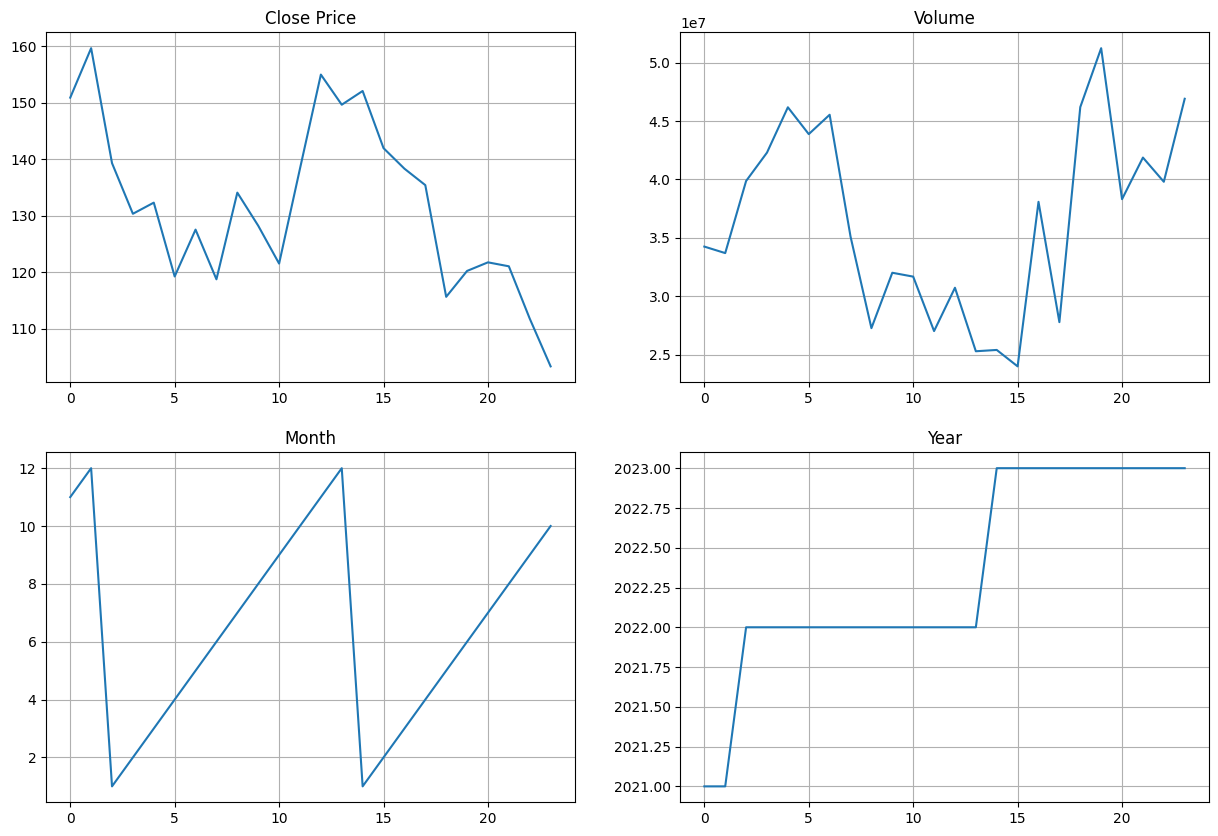

In [26]:
# Plot the data for the first company (AAPL) in the node data as subplots and add grid lines
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(nodes[0, 0, :])
axs[0, 0].set_title('Close Price')
axs[0, 0].grid(True)
axs[0, 1].plot(nodes[0, 1, :])
axs[0, 1].set_title('Volume')
axs[0, 1].grid(True)
axs[1, 0].plot(nodes[0, 2, :])
axs[1, 0].set_title('Month')
axs[1, 0].grid(True)
axs[1, 1].plot(nodes[0, 3, :])
axs[1, 1].set_title('Year')
axs[1, 1].grid(True)
plt.show()





## Training the GNN

In [27]:
import torch.nn.functional as F
n_hidden_nodes = 96
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features):
        super(TemporalGNN, self).__init__()
        self.recurrent = TGCN(in_channels=node_features, 
                              out_channels=n_hidden_nodes,
                              add_self_loops=False)
        self.linear = torch.nn.Linear(n_hidden_nodes, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = F.dropout(y, training=self.training, p=0.1)
        y = self.linear(y)
        return y, h

In [28]:
device = torch.device('cpu') # cuda
model = TemporalGNN(node_features=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# add an exponential learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99, verbose=False)
total_train_loss = []
total_val_loss = []

In [29]:

# Move the data to the GPU
norm_nodes_train = norm_nodes_train.cpu()
norm_targets_train = norm_targets_train.cpu()
norm_nodes_val = norm_nodes_val.cpu()
norm_targets_val = norm_targets_val.cpu()
edges = edges.cpu()
edge_wts = edge_wts.cpu()
model = model.cpu()


print("Running training...")

for epoch in tqdm(range(3000)): 
    train_loss = 0
    # Assign train_hidden_state to empty tensor on first epoch
    train_hidden_state = torch.zeros((norm_nodes_train.shape[0], n_hidden_nodes)).cpu()
    model.train()
    for step in range(norm_targets_train.shape[1]): 
        snapshot = norm_nodes_train[:,:,step:step+1]
        x = snapshot.squeeze()
        # Get model predictions
        y_hat, train_hidden_state = model(x=x, edge_index=edges, edge_weight=edge_wts, prev_hidden_state=train_hidden_state)
        #print(y_hat)
        # Mean squared error
        target = norm_targets_train[:,step:step+1]
        train_loss = train_loss + torch.mean((y_hat - target)**2)
      
    train_loss = train_loss / (step+1)    
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    total_train_loss.append(train_loss.item())
    y_hat_train = y_hat

    val_hidden_state = train_hidden_state

    # Compute validation loss
    val_loss = 0
    model.eval()
    # Store for analysis
    for step in range(norm_targets_val.shape[1]): 
        snapshot = norm_nodes_val[:,:,step:step+1]
        x = snapshot.squeeze()
        # Get model predictions
        y_hat, val_hidden_state = model(x=x, edge_index=edges, edge_weight=edge_wts, prev_hidden_state=val_hidden_state)
        #print(y_hat)
        # Mean squared error
        target = norm_targets_val[:,step:step+1]
        val_loss = val_loss + torch.mean((y_hat - target)**2)
        
    val_loss = val_loss / (step+1)
    total_val_loss.append(val_loss.item())
    y_hat_val = y_hat
    



print(f"Epoch {epoch} train MSE loss: {train_loss.item():.4f}")
print(f"{y_hat_train.T}|{norm_targets_train[:,step:step+1].T}")
print(f"Epoch {epoch} val MSE loss: {val_loss.item():.4f}")
print(f"{y_hat_val.T}|{norm_targets_val[:,step:step+1].T}")


Running training...


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 2999 train MSE loss: 0.1400
tensor([[-1.6417e-01, -1.3611e-01, -1.3092e-01, -1.0666e-01,  3.8505e-01,
          6.3912e-01, -1.9927e-01, -1.3149e-01,  1.7076e-01, -1.3353e-01,
         -2.8679e-01, -6.9389e-02, -4.6587e-01,  1.9031e-01, -5.6487e-01,
          8.0100e+00,  1.6489e+00, -3.8534e-01, -3.9997e-01,  2.3273e-01,
          3.8877e-01, -4.1766e-01, -4.7834e-01, -3.6426e-01, -2.7006e-01,
          1.0387e+00,  9.9661e-02, -3.6177e-01,  8.8133e-02,  2.3907e-01,
         -1.4934e-01, -2.2690e-01, -5.1393e-01, -4.3198e-01, -4.2885e-01,
          9.2044e-05, -2.8684e-01,  9.8056e-02, -1.8680e-01, -2.2906e-01,
         -2.3356e-01, -1.4231e-01,  3.2470e-01,  1.8934e-01, -3.1853e-02,
         -3.2850e-01, -2.1901e-01, -2.8128e-01, -2.8359e-01, -3.5915e-01,
         -3.5900e-01,  8.4067e-01,  2.4489e-02, -1.6410e-01,  4.3671e-01,
          3.1711e-01, -3.4598e-01, -2.6141e-01, -2.3935e-01, -3.3514e-01,
         -2.8298e-01, -2.8094e-01,  4.6647e-01,  1.0535e-01, -2.0280e-01,
    

In [30]:
# Move the data to the CPU for plotting
norm_nodes_train = norm_nodes_train.cpu()
norm_targets_train = norm_targets_train.cpu()
norm_nodes_val = norm_nodes_val.cpu()
norm_targets_val = norm_targets_val.cpu()
edges = edges.cpu()
edge_wts = edge_wts.cpu()
y_hat_train = y_hat_train.cpu()
y_hat_val = y_hat_val.cpu()
model = model.cpu()

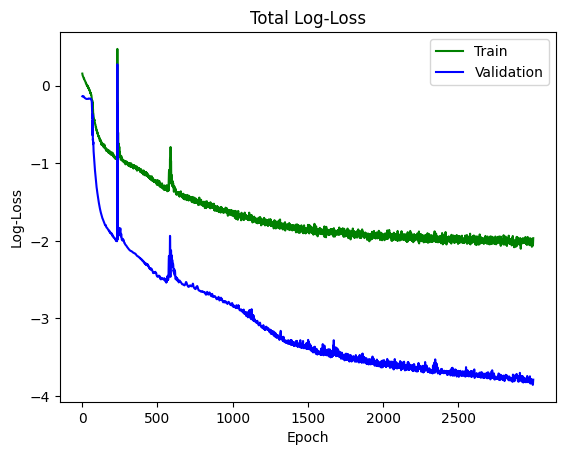

In [55]:
# plot the total loss
plt.plot(np.log(total_train_loss), 'g', label='Train')
plt.plot(np.log(total_val_loss), 'b', label='Validation')
plt.legend(loc='upper right')
plt.title('Total Log-Loss')
plt.xlabel('Epoch')
plt.ylabel('Log-Loss')
plt.xticks(np.arange(0, len(total_train_loss), 500))
plt.show()


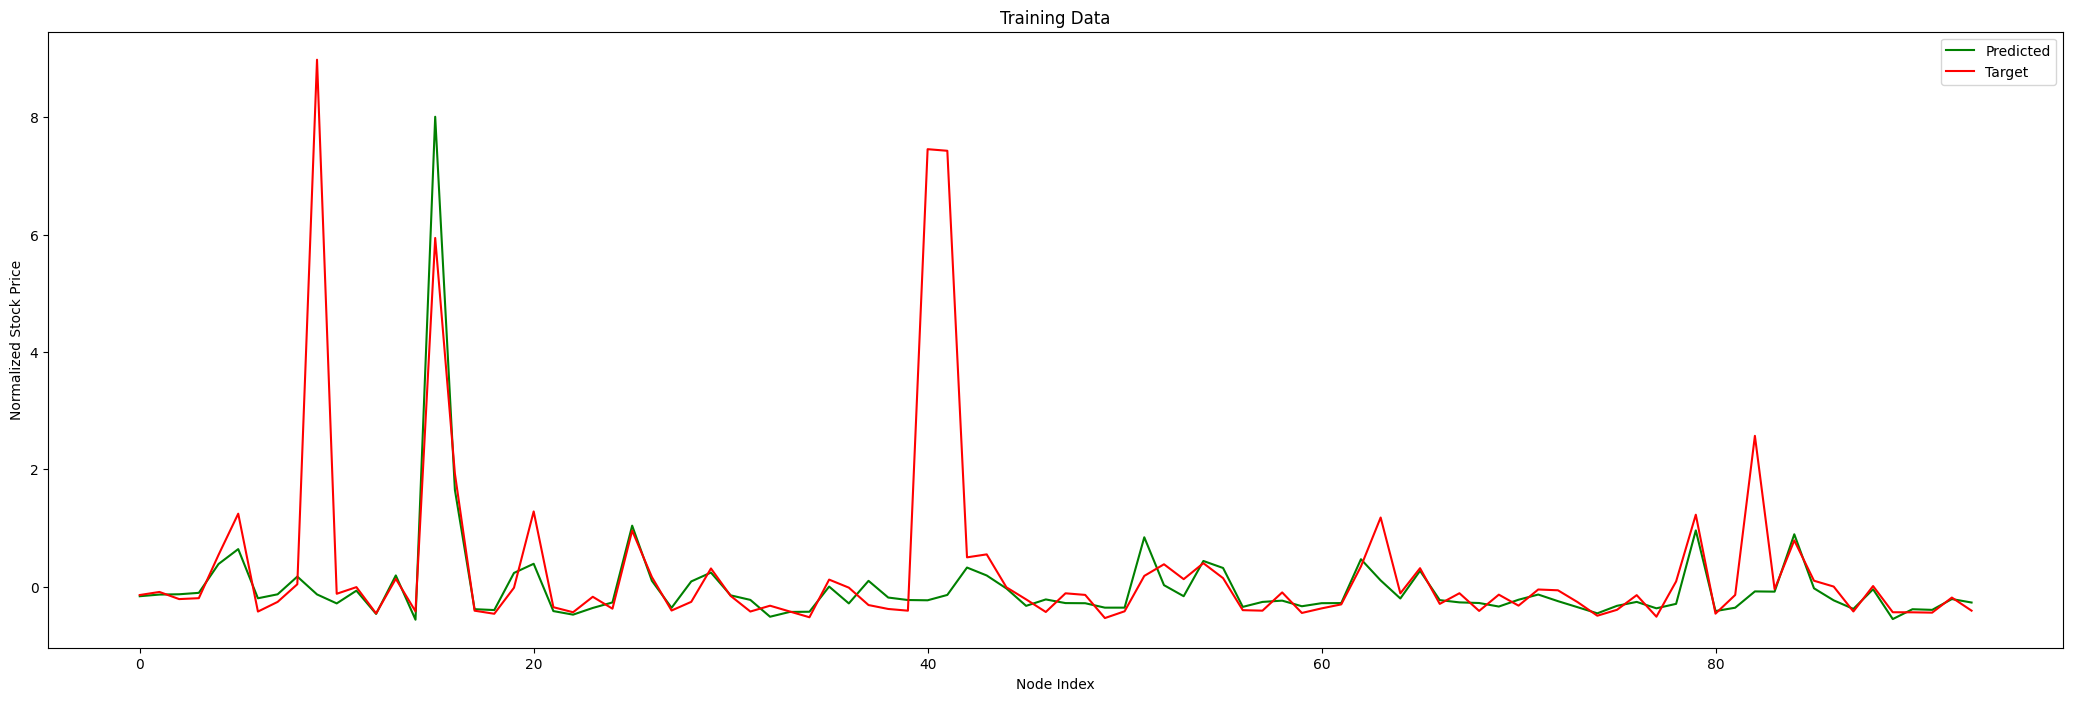

In [54]:
# Plot the node estimates vs the targets
plt.figure(figsize=(26, 8))
plt.plot(y_hat_train.detach().numpy(), 'g', label='Predicted')
plt.plot(norm_targets_train[:,step:step+1].cpu().detach().numpy(), 'r', label='Target')
plt.legend()
plt.ylabel('Normalized Stock Price')
plt.xlabel('Node Index')
plt.title('Training Data')
plt.show()

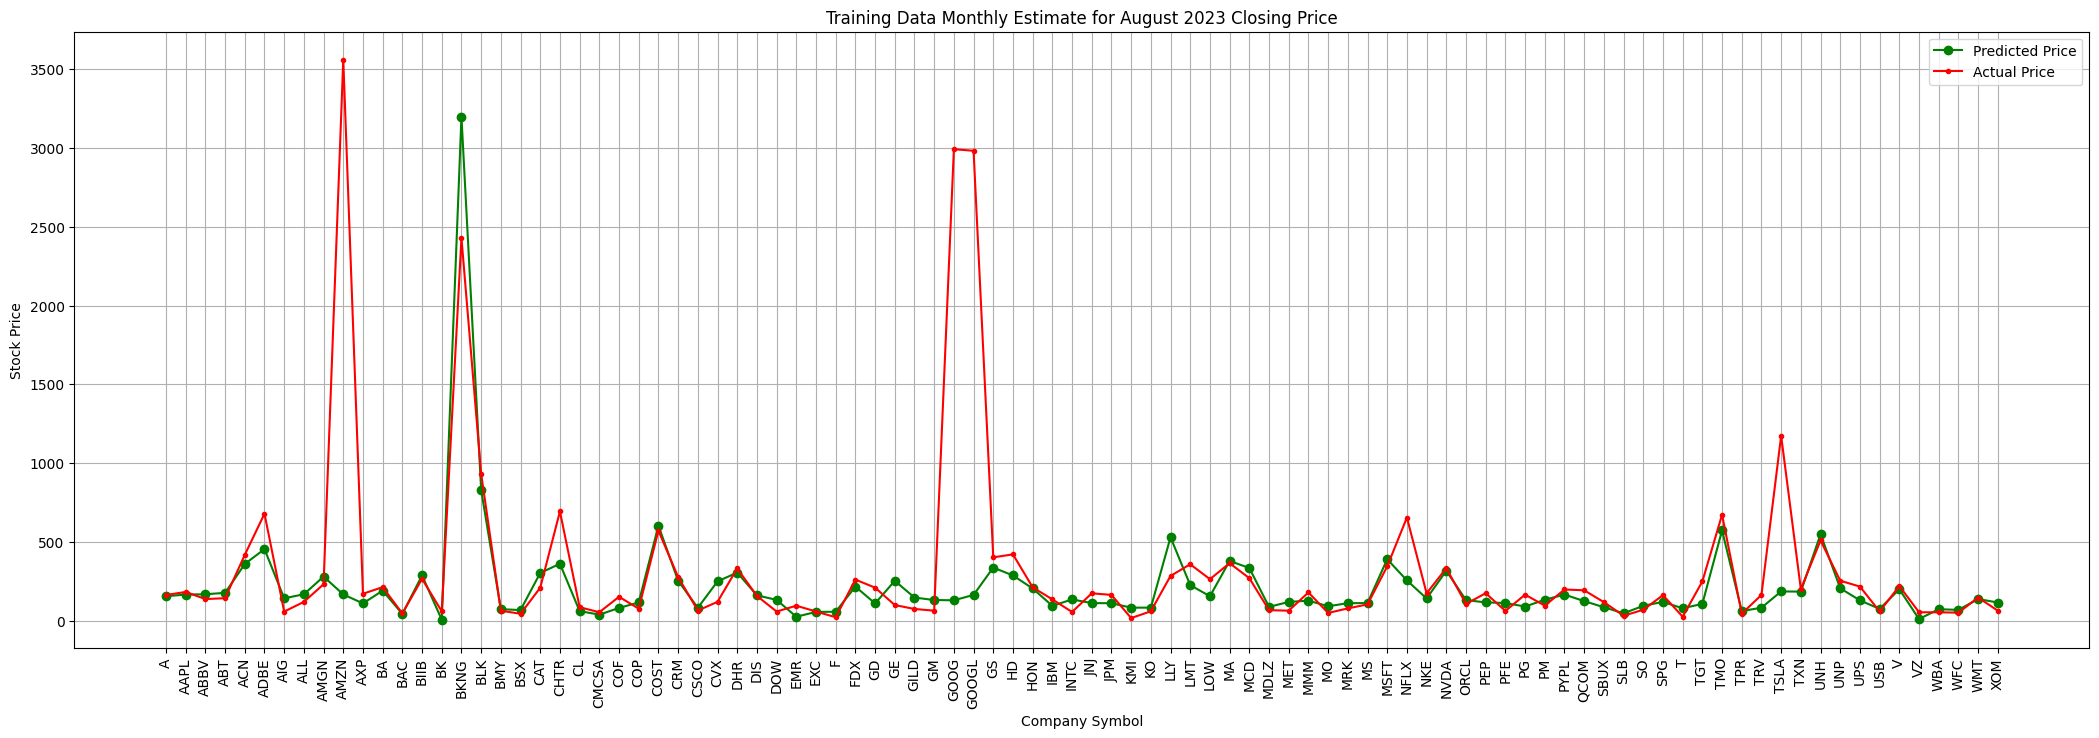

In [56]:
# Plot the unnormalized node estimates vs the targets
unnorm_y_hat_train = y_hat_train.detach().numpy() * scaler.scale_[0] + scaler.mean_[0]
unnorm_targets_train = norm_targets_train[:,step:step+1].detach().numpy() * scaler.scale_[0] + scaler.mean_[0]
plt.figure(figsize=(26, 8))
plt.plot(unnorm_y_hat_train, 'go-', label='Predicted Price')
plt.plot(unnorm_targets_train, 'r.-', label='Actual Price')
plt.legend()
plt.ylabel('Stock Price')
plt.xlabel('Company Symbol')
plt.title('Training Data Monthly Estimate for August 2023 Closing Price')
plt.grid(True)
# replace the xticks with the names of the companies rotated vertically
plt.xticks(np.arange(len(company_symbols)), company_symbols, rotation='vertical')
plt.show()


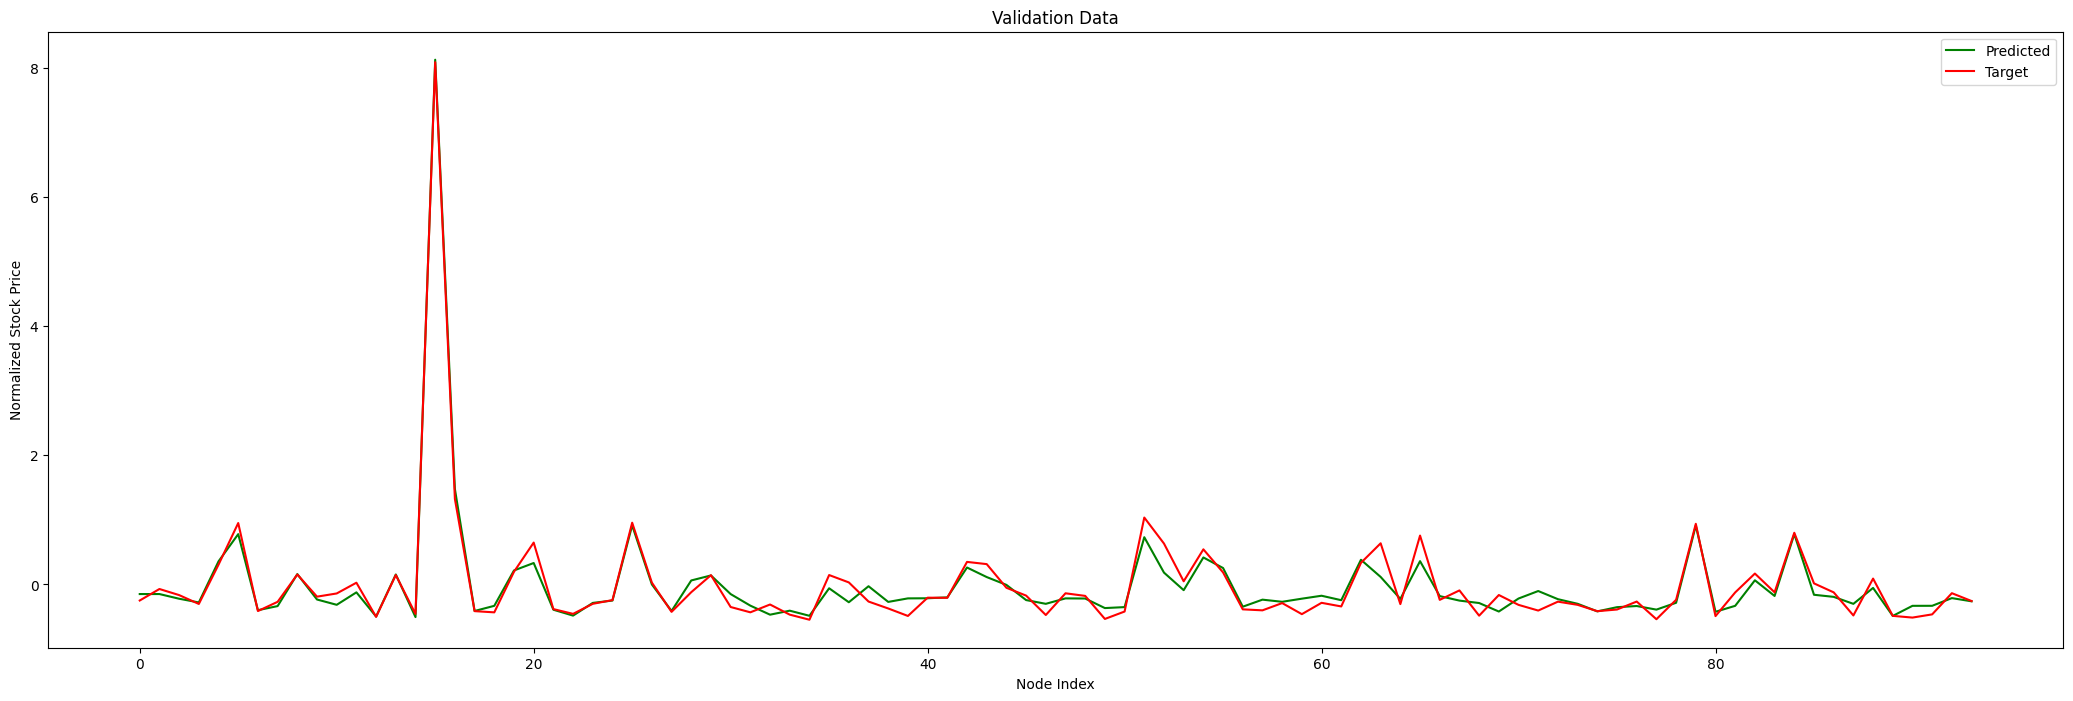

In [49]:
# Plot the node estimates vs the targets
plt.figure(figsize=(26, 8))
plt.plot(y_hat_val.detach().numpy(), 'g', label='Predicted')
plt.plot(norm_targets_val[:,step:step+1].detach().numpy(), 'r', label='Target')
plt.legend()
plt.ylabel('Normalized Stock Price')
plt.xlabel('Node Index')
plt.title('Validation Data')
plt.show()

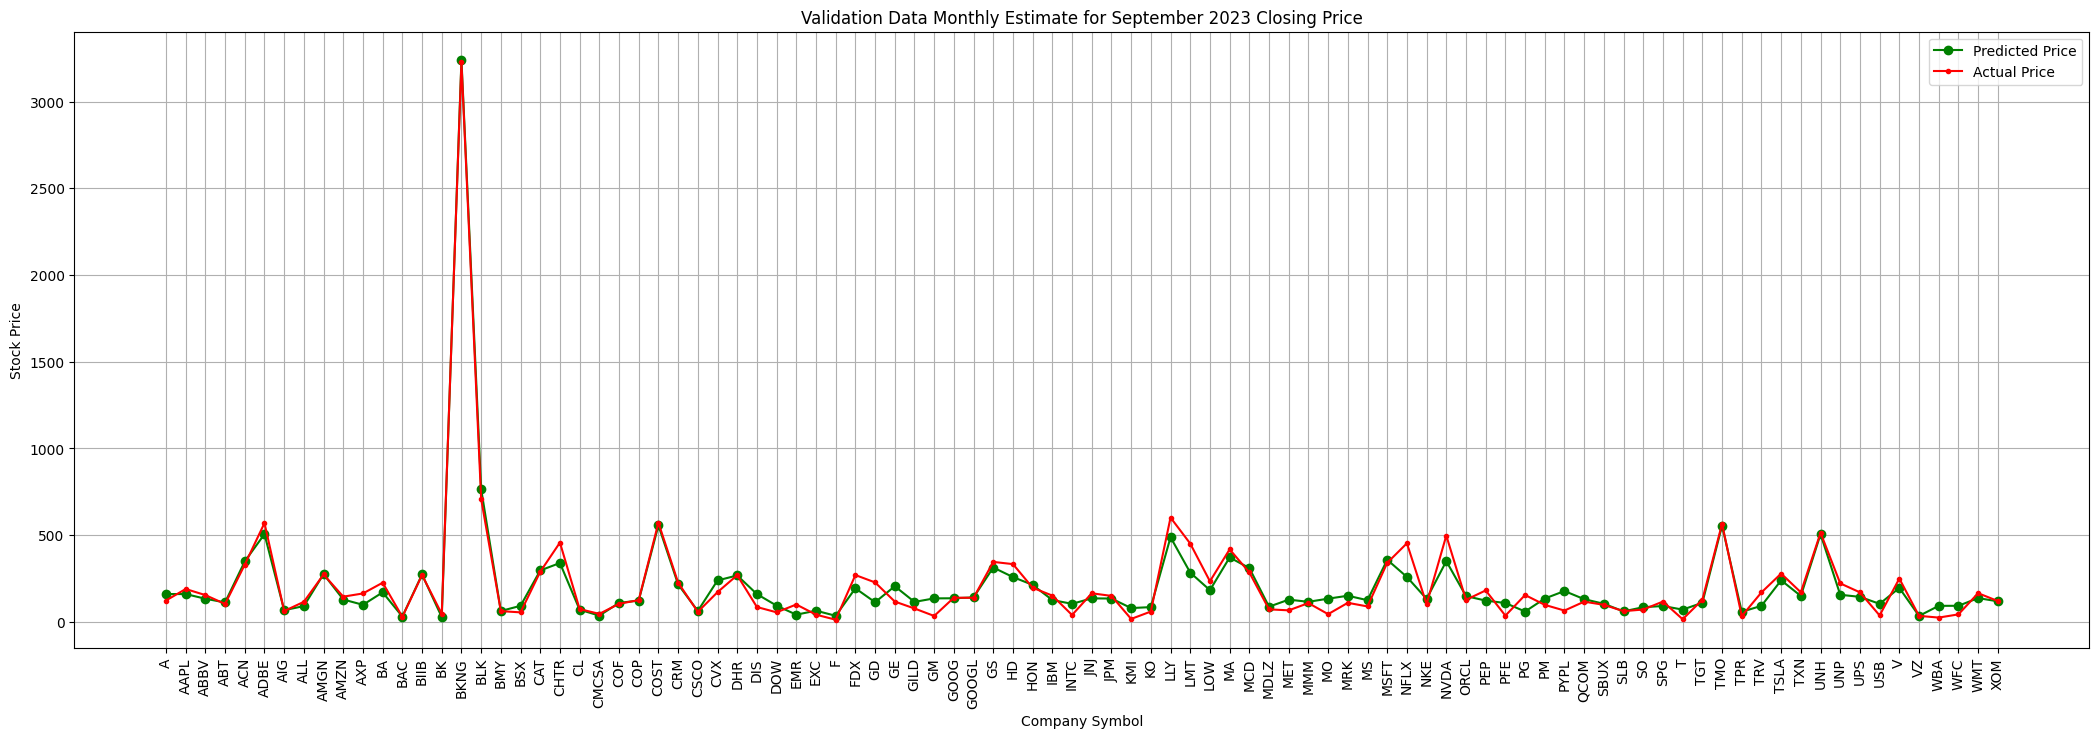

In [53]:
# Plot the unnormalized node estimates vs the targets
unnorm_y_hat_val = y_hat_val.detach().numpy() * scaler.scale_[0] + scaler.mean_[0]
unnorm_targets_val = norm_targets_val[:,step:step+1].detach().numpy() * scaler.scale_[0] + scaler.mean_[0]
plt.figure(figsize=(26, 8))
plt.plot(unnorm_y_hat_val, 'go-', label='Predicted Price')
plt.plot(unnorm_targets_val, 'r.-', label='Actual Price')
plt.legend()
plt.ylabel('Stock Price')
plt.xlabel('Company Symbol')
plt.title('Validation Data Monthly Estimate for September 2023 Closing Price')
plt.grid(True)
# replace the xticks with the names of the companies rotated vertically
plt.xticks(np.arange(len(company_symbols)), company_symbols, rotation='vertical')
plt.show()

In [59]:
test_hidden_state = val_hidden_state.cpu()


# Compute testing loss
test_loss = 0
model.eval()
# Store for analysis
for step in range(norm_targets_test.shape[1]): 
    snapshot = norm_nodes_test[:,:,step:step+1]
    x = snapshot.squeeze()
    # Get model predictions
    y_hat, test_hidden_state = model(x=x, edge_index=edges, edge_weight=edge_wts, prev_hidden_state=test_hidden_state)
    #print(y_hat)
    # Mean squared error
    target = norm_targets_test[:,step:step+1]
    test_loss = test_loss + torch.mean((y_hat - target)**2)
    
test_loss = test_loss / (step+1)
y_hat_test = y_hat.cpu()


print(f"Epoch {epoch} validation MSE loss: {val_loss.item():.4f}")
print(f"{y_hat_val.T}|{norm_targets_val[:,step:step+1].T}")
print(f"Epoch {epoch} test MSE loss: {test_loss:.4f}")
print(f"{y_hat_test.T}|{norm_targets_test[:,step:step+1].T}")

Epoch 2999 validation MSE loss: 0.0226
tensor([[-1.4845e-01, -1.4845e-01, -2.2103e-01, -2.7852e-01,  3.5783e-01,
          7.7937e-01, -3.9838e-01, -3.3492e-01,  1.6062e-01, -2.3300e-01,
         -3.1508e-01, -1.2221e-01, -4.9687e-01,  1.5466e-01, -5.0506e-01,
          8.1258e+00,  1.4781e+00, -4.1075e-01, -3.3079e-01,  2.1694e-01,
          3.3223e-01, -3.9104e-01, -4.8250e-01, -2.8566e-01, -2.4902e-01,
          9.1520e-01,  4.5463e-04, -4.1034e-01,  6.2093e-02,  1.3959e-01,
         -1.4896e-01, -3.2792e-01, -4.6799e-01, -4.0602e-01, -4.8513e-01,
         -5.9195e-02, -2.7535e-01, -2.7379e-02, -2.7019e-01, -2.1548e-01,
         -2.1367e-01, -1.9994e-01,  2.6233e-01,  1.1464e-01, -6.5093e-03,
         -2.4180e-01, -2.9972e-01, -2.1547e-01, -2.1770e-01, -3.6565e-01,
         -3.5067e-01,  7.3150e-01,  1.8356e-01, -8.8364e-02,  4.1812e-01,
          2.5447e-01, -3.4438e-01, -2.3523e-01, -2.6839e-01, -2.2004e-01,
         -1.7456e-01, -2.4365e-01,  3.8243e-01,  1.1649e-01, -2.2373e-01,

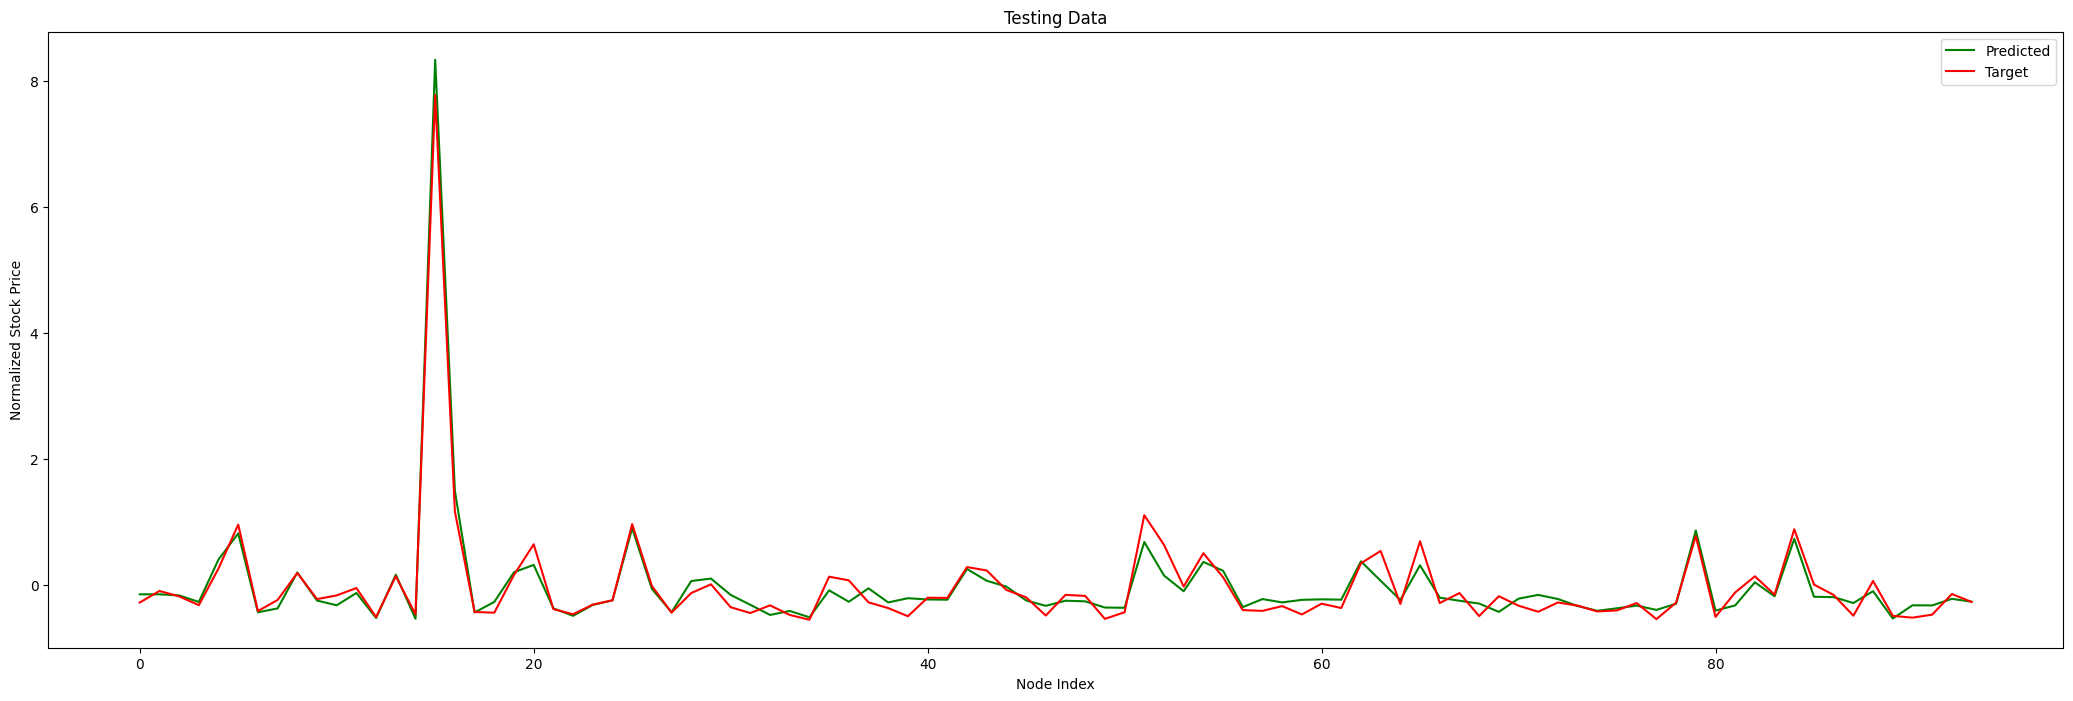

In [60]:

#Plot the node estimates vs the targets
plt.figure(figsize=(26, 8))
plt.plot(y_hat_test.detach().numpy(), 'g', label='Predicted')
plt.plot(norm_targets_test[:,step:step+1].detach().numpy(), 'r', label='Target')
plt.legend()
plt.ylabel('Normalized Stock Price')
plt.xlabel('Node Index')
plt.title('Testing Data')
plt.show()

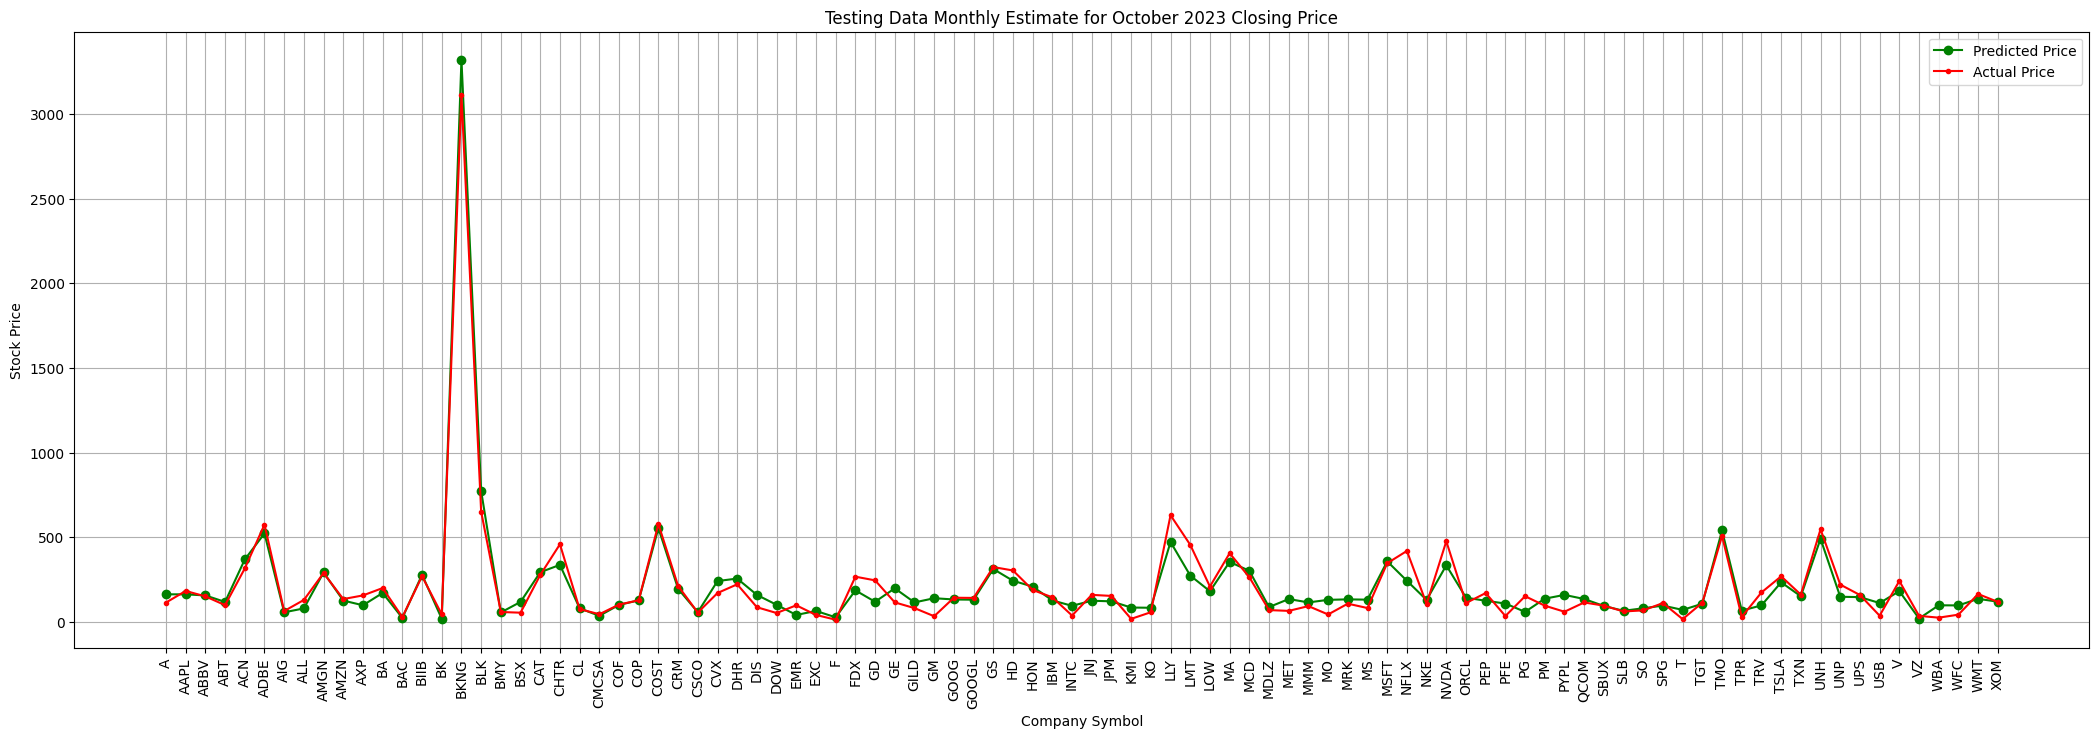

In [58]:
# Plot the unnormalized node estimates vs the targets
unnorm_y_hat_test = y_hat_test.detach().numpy() * scaler.scale_[0] + scaler.mean_[0]
unnorm_targets_test = norm_targets_test[:,step:step+1].detach().numpy() * scaler.scale_[0] + scaler.mean_[0]
plt.figure(figsize=(26, 8))
plt.plot(unnorm_y_hat_test, 'go-', label='Predicted Price')
plt.plot(unnorm_targets_test, 'r.-', label='Actual Price')
plt.legend()
plt.ylabel('Stock Price')
plt.xlabel('Company Symbol')
plt.title('Testing Data Monthly Estimate for October 2023 Closing Price')
plt.grid(True)
# replace the xticks with the names of the companies rotated vertically
plt.xticks(np.arange(len(company_symbols)), company_symbols, rotation='vertical')
plt.show()